Catcher Framing References

[1] https://www.baseballprospectus.com/news/article/25514/moving-beyond-wowy-a-mixed-approach-to-measuring-catcher-framing/
[2] https://www.fangraphs.com/blogs/pitch-framing-data-is-going-insane/

The gold-standard BP model "CSAA" (Called Strikes Above Average) is outlined in [1]. This is a mixed effects model which uses modelled called strike probability (cs_prob) and half-innging (half) as fixed effects, while adjusting for catcher, pitcher, umpire, batter, and catcher:cs_prob interaction as the random effects. The random effects are modelled as such because they are assumed to be dependent - the impact of the individual catcher is modulated by the pitcher, umpire, batter, and cs_prob, and the other individual impact of each variable is modulated by the other random effects variables in the same way. These random effects have are assumed to have a linear contribution to the likelihood of a strike. 



In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import copy
import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import svm, ensemble

np.random.seed(5)
random_seed = np.random.randint(0,10000)
random_seed

2915

In [2]:
filepath = '/Users/dangoldberg/Desktop/DataScienceInterviewProjects/Toronto Blue Jays/catcherframe.csv'

In [3]:
df = pd.read_csv(filepath)

In [4]:
df.columns

Index(['parkid', 'bluejaysgameid', 'gamepitchsequence', 'half', 'balls',
       'strikes', 'pitcherid', 'pitcherhand', 'batterid', 'batside',
       'catcherid', 'pitchtype', 'relspeed', 'hbreak', 'vbreak', 'plate_x',
       'plate_z', 'calledstrike', 'ball', 'swings', 'takes', 'pitchout',
       'intentball', 'inplay', 'pitcheventtype', 'hbp', 'ump_hp'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342506 entries, 0 to 342505
Data columns (total 27 columns):
parkid               342506 non-null int64
bluejaysgameid       342506 non-null object
gamepitchsequence    342506 non-null int64
half                 342506 non-null int64
balls                342506 non-null int64
strikes              342506 non-null int64
pitcherid            342506 non-null int64
pitcherhand          342506 non-null object
batterid             342506 non-null int64
batside              342506 non-null object
catcherid            342506 non-null int64
pitchtype            342506 non-null object
relspeed             342506 non-null float64
hbreak               342506 non-null float64
vbreak               342506 non-null float64
plate_x              342506 non-null float64
plate_z              342506 non-null float64
calledstrike         342506 non-null int64
ball                 342506 non-null int64
swings               342506 non-null int64
takes          

In [6]:

# impute missing ump ids as -1
df['ump_hp'] = df['ump_hp'].replace(np.nan, -1).astype(str)

In [81]:
# only look at called strikes for framing

data = df[(df['swings'] == 0) & (df['intentball'] == 0)]

In [82]:
#feature engineering

base_columns = [
    'strikes',
    'balls',
    'batside',
    'pitchtype',
    'ump_hp',
    'relspeed',
    'plate_x',
    'plate_z',
    'hbreak',
    'vbreak'
]

categoricals = [
    'count_state',
    'batside',
    'pitchtype',
    'pitcherhand',
    'ump_hp'
]

continuous = [
    'relspeed',
    'plate_x',
    'plate_z',
    'hbreak',
    'vbreak'
]

labels = data['calledstrike']
data.drop('calledstrike', axis=1, inplace=True)
data = data[base_columns]

data['count_state'] = data.apply(lambda df: str(df['balls']) + str(df['strikes']), axis=1)


# one-hot-encoding of count state
# one-hot-encoding of pitcherhand
# one-hot-encoding of batside
# one-hot-encoding of pitchtype
# one-hot-encoding of ump

one_hot_encoder = preprocessing.OneHotEncoder(sparse=False).fit(data[categoricals])
cat_df = pd.DataFrame(one_hot_encoder.transform(data[categoricals]))
cat_df.columns = one_hot_encoder.get_feature_names(categoricals)
data = data.reset_index(drop=True).merge(cat_df, how='inner', left_index=True, right_index=True)
labels = labels.reset_index(drop=True)
data.drop(categoricals, axis=1, inplace=True)

print(data.shape, labels.shape)

/Users/dangoldberg/miniconda3/envs/tbj/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


(182944, 93) (182944,)


# Try some simple models

In [85]:
def train_and_score_classifier(clf, data, lables, frac=1.0):
    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.16, random_state=random_seed)

    # standard-scale continuous variables
    scaler = preprocessing.StandardScaler().fit(X_train[continuous])
    X_train, X_test = preprocess_after_split(X_train,scaler), preprocess_after_split(X_test,scaler)

    # use smaller dataset to test iteration
    X_train, y_train = use_train_subset(X_train, y_train, frac=frac)
    
    # train model
    clf.fit(X_train, y_train)
    return clf.score(X_train, y_train), clf.score(X_test,y_test), clf, scaler
    
def preprocess_after_split(X, scaler):
    X.loc[:,continuous] = scaler.transform(X[continuous])
    return X

def use_train_subset(X, y, frac):
    sample_index = X.sample(frac=frac).index
    X = X.loc[sample_index]
    y = y.loc[sample_index]
    return X, y



In [17]:
models = {}

RBF Support Vector Machine

In [62]:
c_params = np.logspace(-1, 2, 4)

models = models['svc']:{}
for c in c_params:
    clf = svm.SVC(C=c)
    train_score, test_score, clf, _ = train_and_score_classifier(clf, data, labels, frac=0.1)
    models['svc'][c] = {'train_score':train_score, 'test_score':test_score, 'clf':clf}
models

SyntaxError: invalid syntax (<ipython-input-62-d167ef657006>, line 3)

Random Forest

In [74]:
max_depth_params = np.logspace(1, 4, 4)

models['rf'] = {}
for max_depth in max_depth_params:
    clf = ensemble.RandomForestClassifier(max_depth=max_depth, n_estimators=100)
    train_score, test_score, clf, _ = train_and_score_classifier(clf, data, labels, frac=0.66)
    models['rf'][max_depth] = {'train_score':train_score, 'test_score':test_score, 'clf':clf}

models

/Users/dangoldberg/miniconda3/envs/tbj/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/dangoldberg/miniconda3/envs/tbj/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/dangoldberg/miniconda3/envs/tbj/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

{'rf': {10.0: {'train_score': 0.8567597412841143,
   'test_score': 0.8526919923476359,
   'clf': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
               max_depth=10.0, max_features='auto', max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
               oob_score=False, random_state=None, verbose=0,
               warm_start=False)},
  100.0: {'train_score': 1.0,
   'test_score': 0.904892047007379,
   'clf': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
               max_depth=100.0, max_features='auto', max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
               oob_score=False, r

In [84]:
cal_data = data.copy()

cal_data.loc[:,continuous] = preprocessing.StandardScaler().fit(cal_data[continuous]).transform(cal_data[continuous])
models['rf'][100]['clf'].score(cal_data,labels)

0.9581073989854819

In [95]:
from sklearn import calibration

def plot_calibration_curve(labels, proba, n_bins=10):
    prob_true, prob_pred = calibration.calibration_curve(labels, proba, normalize=False, n_bins=10)
    plt.plot(prob_pred,prob_true)
    #plt.hist(prob_pred, bins=10)
    plt.show()

/Users/dangoldberg/miniconda3/envs/tbj/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/dangoldberg/miniconda3/envs/tbj/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


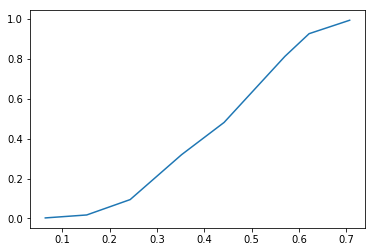

In [96]:
model = ensemble.RandomForestClassifier(max_depth=10, n_estimators=100)
train_score, test_score, model, scaler = train_and_score_classifier(model, data, labels, frac=1.0)

cal_data = data.copy()
cal_data.loc[:,continuous] = preprocessing.StandardScaler().fit(cal_data[continuous]).transform(cal_data[continuous])

proba = model.predict_proba(cal_data)[:,1]
preds = model.predict(cal_data)
plot_calibration_curve(labels, proba, n_bins=10)

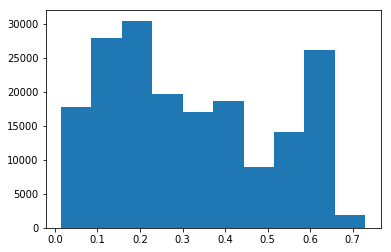

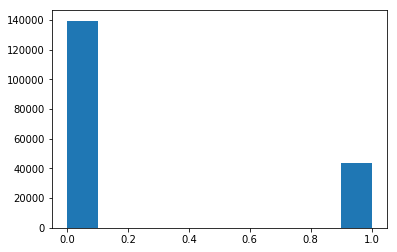

In [97]:
plt.hist(proba)
plt.show()
plt.hist(preds)
plt.show()
plt.hist(labels)
plt.show()

## Calibrate the Model Probabilities

In [98]:
clf = calibration.CalibratedClassifierCV(base_estimator=model, method='isotonic', cv='prefit')

In [99]:
clf.fit(cal_data, labels)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
            cv='prefit', method='isotonic')

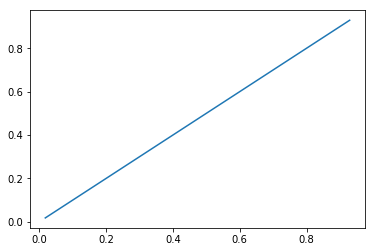

In [100]:
proba = clf.predict_proba(cal_data)[:,1]
preds = clf.predict(cal_data)
plot_calibration_curve(labels, proba, n_bins=10)

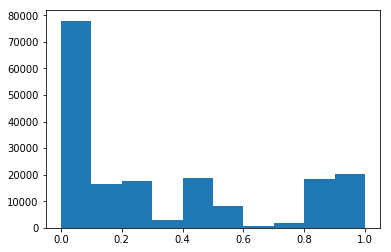

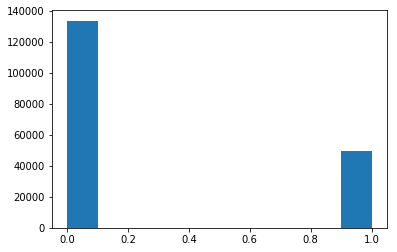

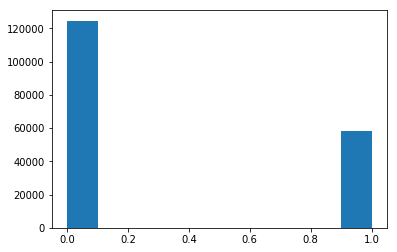

In [102]:
plt.hist(proba)
plt.show()
plt.hist(preds)
plt.show()
plt.hist(labels)
plt.show()

In [169]:

data = df[(df['swings'] == 0) & (df['intentball'] == 0)]
data.loc[:,'cs_prob'] = proba


NameError: name 'proba' is not defined

In [113]:
data.to_csv('data_with_cs_prob.csv',index=False)

# Apply Generalized Linear Mixed Effects Model

In [26]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [170]:
filepath = 'data_with_cs_prob.csv'

In [171]:
df = pd.read_csv(filepath)

In [172]:
df[:5]

,parkid,bluejaysgameid,gamepitchsequence,half,balls,strikes,pitcherid,pitcherhand,batterid,batside,...,ball,swings,takes,pitchout,intentball,inplay,pitcheventtype,hbp,ump_hp,cs_prob
0,5,556C80A4-54E3-400E-9AD1-426D5FB679BB,1,0,0,0,11198,R,171109,R,...,1,0,1,0,0,0,ball,0,142393.0,0.445767
1,5,556C80A4-54E3-400E-9AD1-426D5FB679BB,2,0,1,0,11198,R,171109,R,...,0,0,1,0,0,0,called_strike,0,142393.0,0.808174
2,5,556C80A4-54E3-400E-9AD1-426D5FB679BB,3,0,1,1,11198,R,171109,R,...,1,0,1,0,0,0,ball,0,142393.0,0.008856
3,5,556C80A4-54E3-400E-9AD1-426D5FB679BB,6,0,2,2,11198,R,171109,R,...,1,0,1,0,0,0,ball,0,142393.0,0.021135
4,5,556C80A4-54E3-400E-9AD1-426D5FB679BB,8,0,0,0,11198,R,7327,R,...,1,0,1,0,0,0,ball,0,142393.0,0.865428


In [173]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182944 entries, 0 to 182943
Data columns (total 28 columns):
parkid               182944 non-null int64
bluejaysgameid       182944 non-null object
gamepitchsequence    182944 non-null int64
half                 182944 non-null int64
balls                182944 non-null int64
strikes              182944 non-null int64
pitcherid            182944 non-null int64
pitcherhand          182944 non-null object
batterid             182944 non-null int64
batside              182944 non-null object
catcherid            182944 non-null int64
pitchtype            182944 non-null object
relspeed             182944 non-null float64
hbreak               182944 non-null float64
vbreak               182944 non-null float64
plate_x              182944 non-null float64
plate_z              182944 non-null float64
calledstrike         182944 non-null int64
ball                 182944 non-null int64
swings               182944 non-null int64
takes          

In [174]:
import statsmodels
from scipy.stats import norm


In [124]:
random = {
    'parkid':'C(parkid)',
    'ump_hp':'C(ump_hp)',
    'pitcherid':'C(pitcherid)',
    'batterid':'C(batterid)',
    'catcherid':'C(catcherid)',
    'catcherid:cs_prob':'C(catcherid):cs_prob'
}
model = sm.BinomialBayesMixedGLM.from_formula('calledstrike ~ cs_prob + C(half)', random, df)

# change to probit link function

link = statsmodels.genmod.families.links.probit()
family = sm.genmod.families.family.Binomial(link=link)

model.family = family

In [ ]:
model_fitted = model.fit_vb()

In [127]:
print(model_fitted.summary())

                   Binomial Mixed GLM Results
                  Type Post. Mean Post. SD   VC  VC (LB) VC (UB)
----------------------------------------------------------------
Intercept            F    -3.1023   0.0075                      
C(half)[T.1]         F    -0.0469   0.0108                      
cs_prob              F     6.3348   0.0151                      
parkid               R    -2.8305   0.1485 0.059   0.044   0.079
ump_hp               R    -2.3536   0.0935 0.095   0.079   0.115
pitcherid            R    -1.7117   0.0236 0.181   0.172   0.189
batterid             R    -1.7825   0.0224 0.168   0.161   0.176
catcherid            R    -1.9046   0.0590 0.149   0.132   0.168
catcherid:cs_prob    R    -2.9247   0.0590 0.054   0.048   0.060



In [128]:
def get_random_effect_factors(effect, random):
    factors = [col for col in model_fitted.random_effects().index if random[effect] in col]
    return model_fitted.random_effects().loc[factors,['Mean','SD']]


def plot_effect_factors(effect, random):
    
    factors = get_random_effect_factors(effect, random)
    mean = factors.sort_values('Mean', ascending=False)['Mean']
    std = factors.sort_values('Mean', ascending=False)['SD']

    fig = plt.figure(figsize=(20,10))
    ax = fig.add_axes([0., 0., 1.4, 1.4, ])
    ax.bar(np.arange(len(mean)), mean, yerr=std)
    ax.set_ylabel('coeffs')
    ax.set_title('Random Effects - {}'.format(effect), fontdict={'fontsize':30})
    ax.set_xticks(np.arange(len(mean)))
    ax.set_xticklabels(get_random_effect_factors(effect, random).sort_values('Mean', ascending=False).index, fontdict={'rotation':45})

    fig.show()

/Users/dangoldberg/miniconda3/envs/tbj/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/Users/dangoldberg/miniconda3/envs/tbj/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/Users/dangoldberg/miniconda3/envs/tbj/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/Users/dangoldberg/miniconda3/envs/tbj/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend

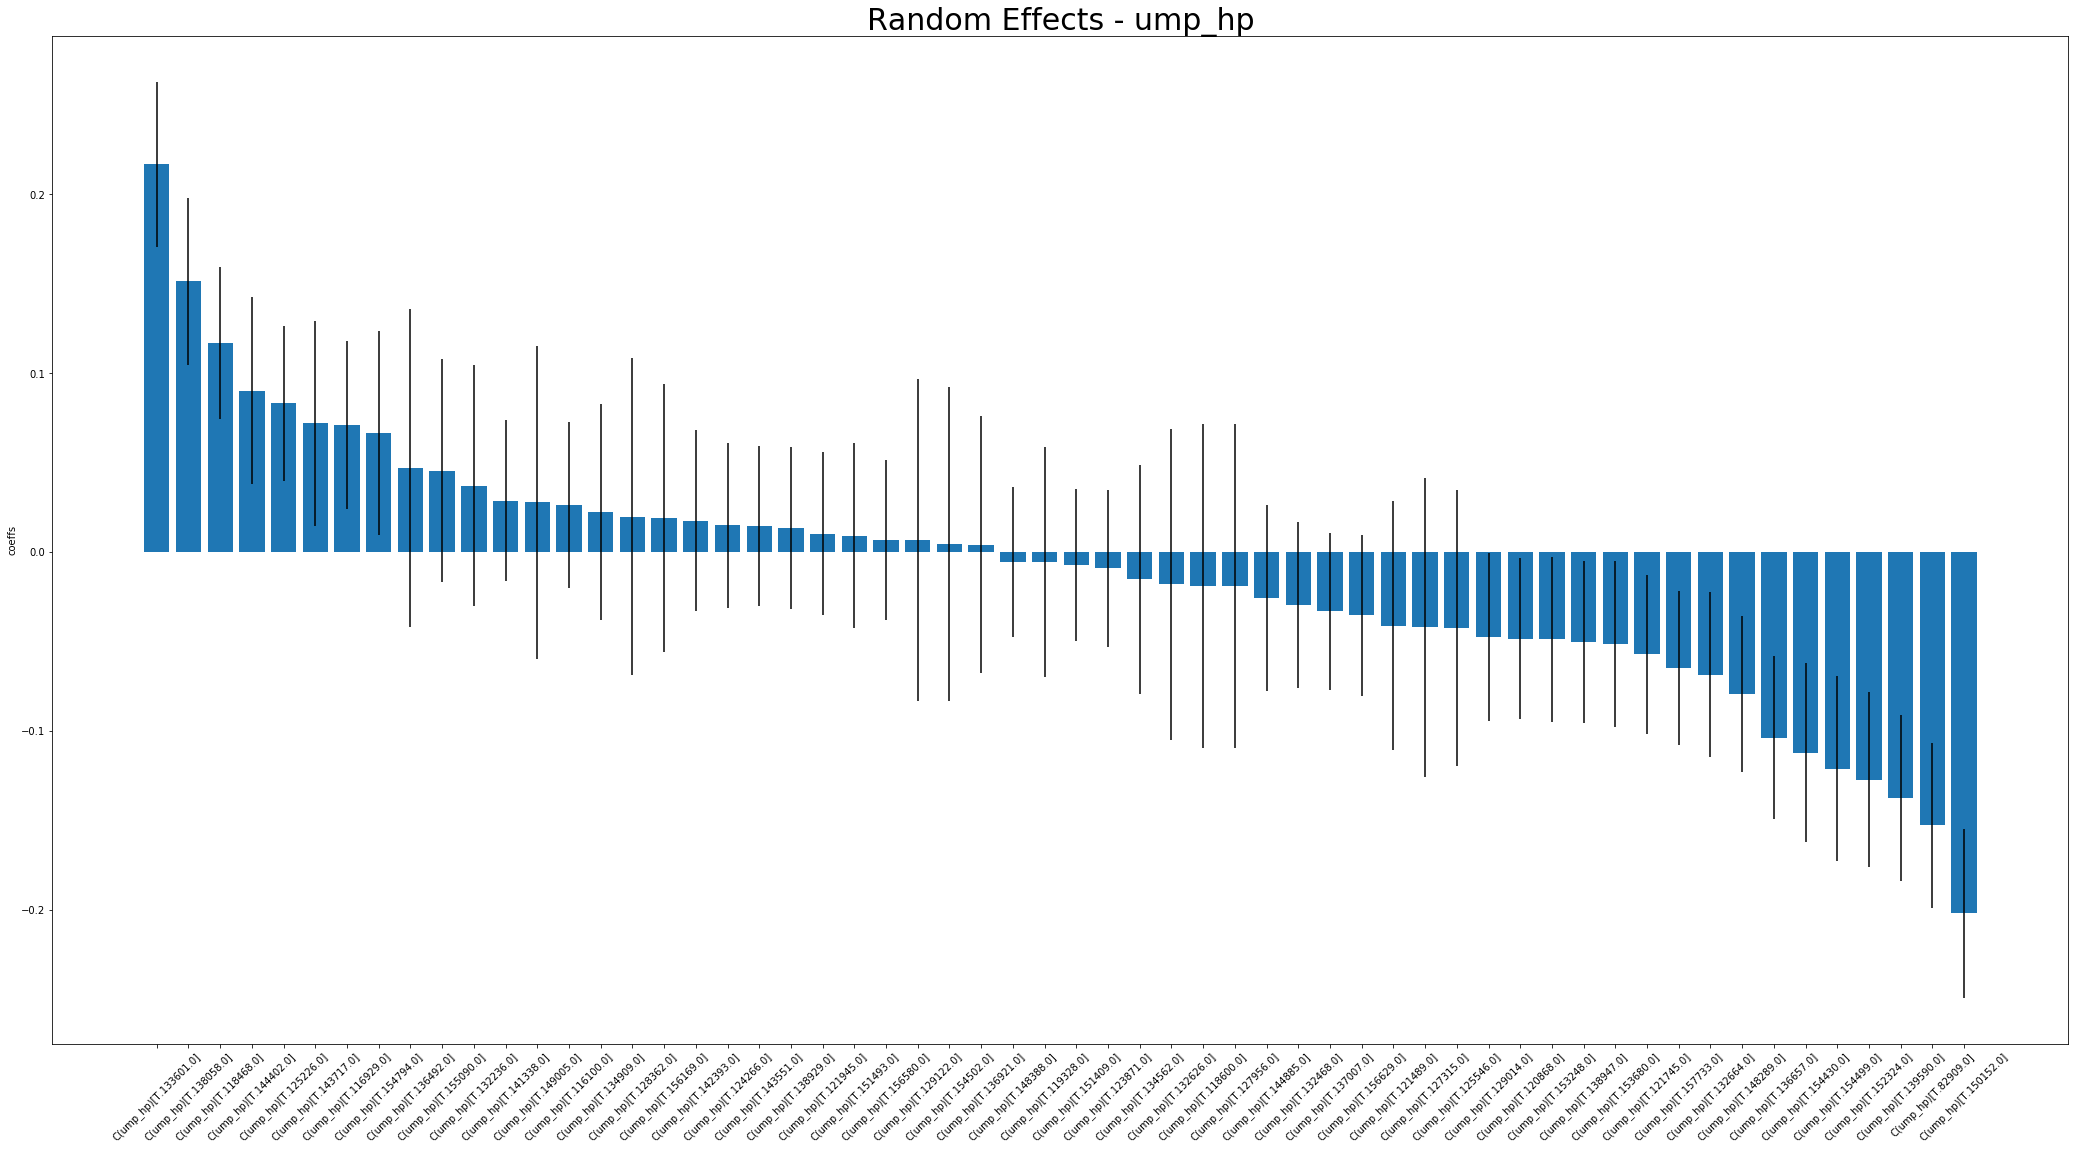

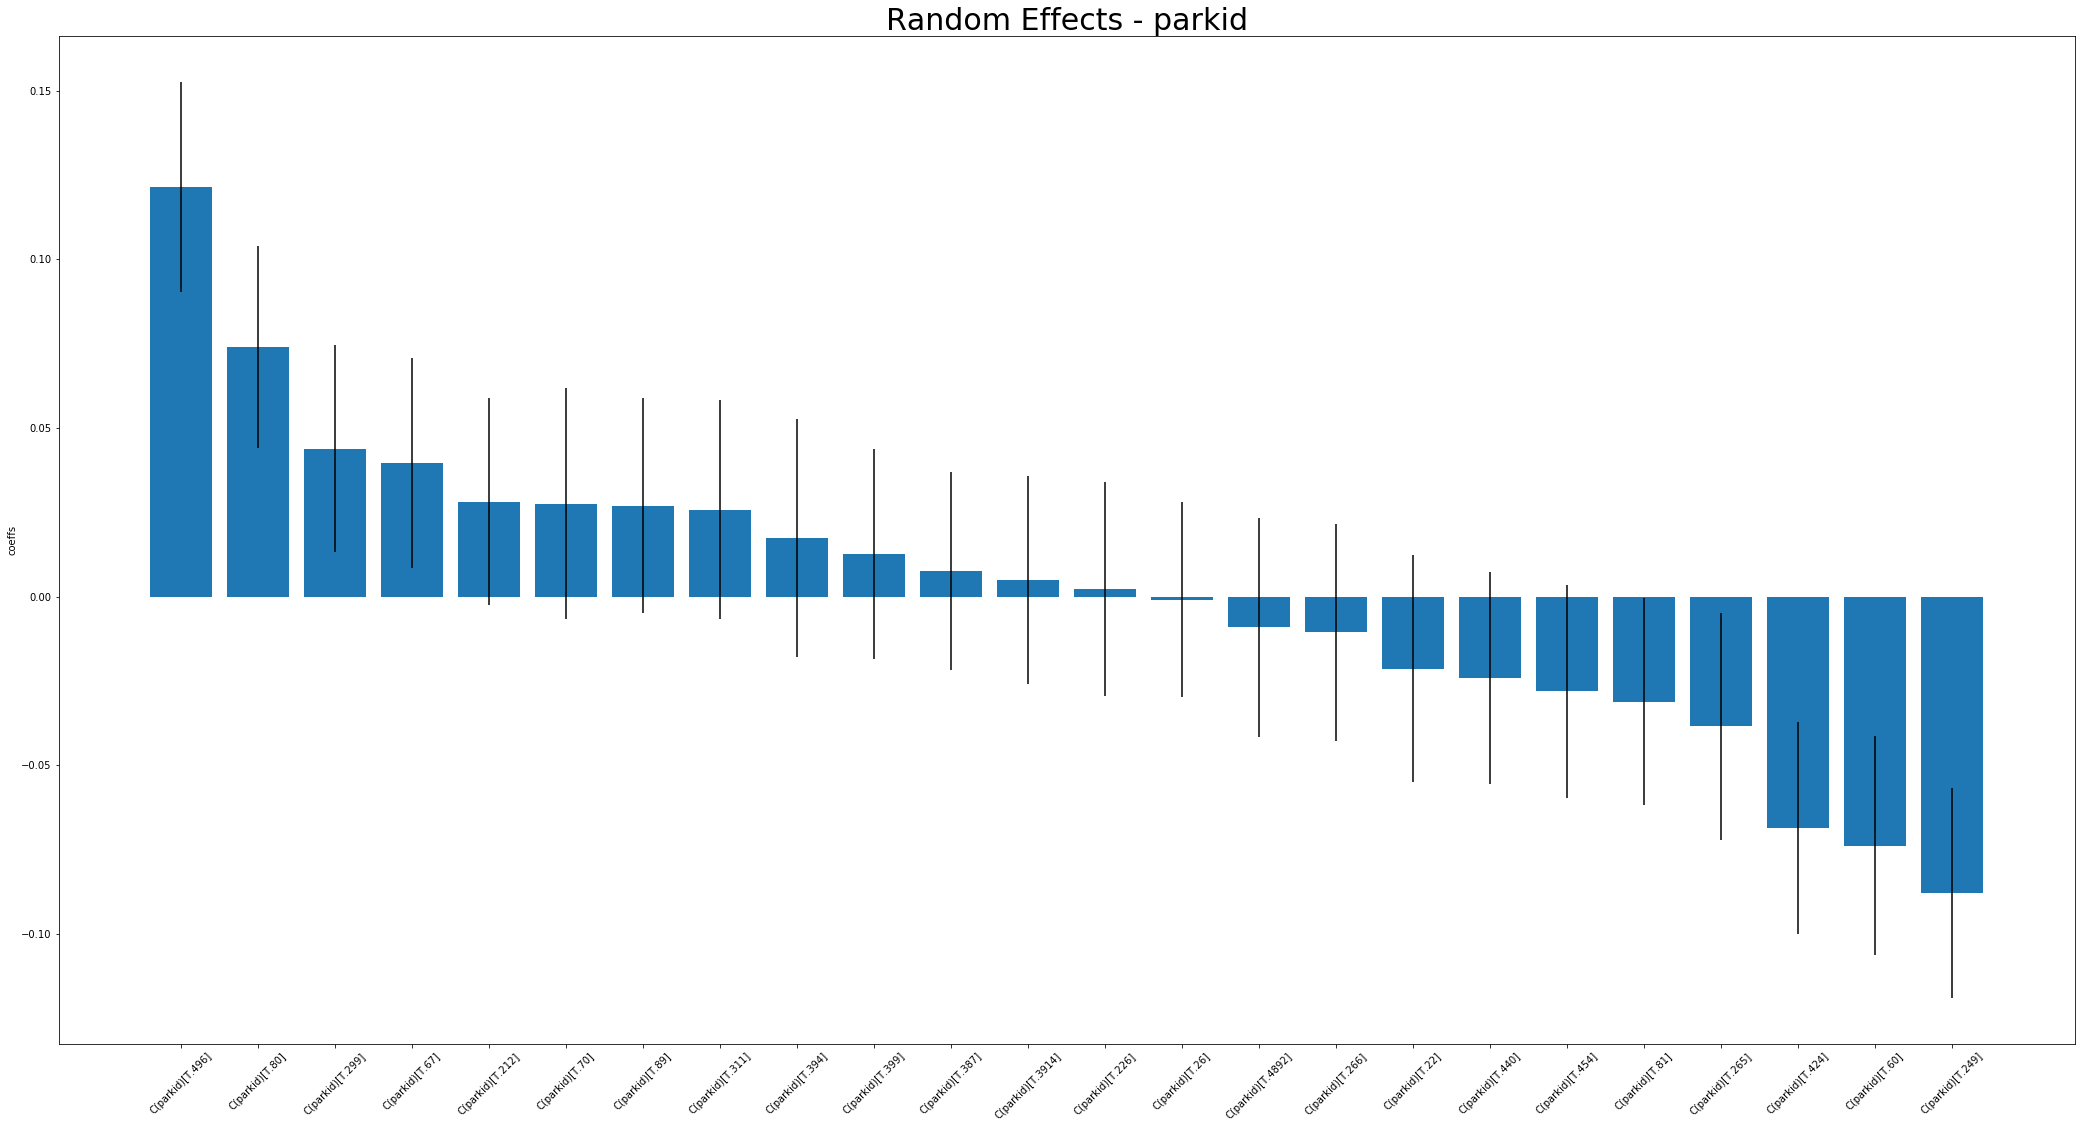

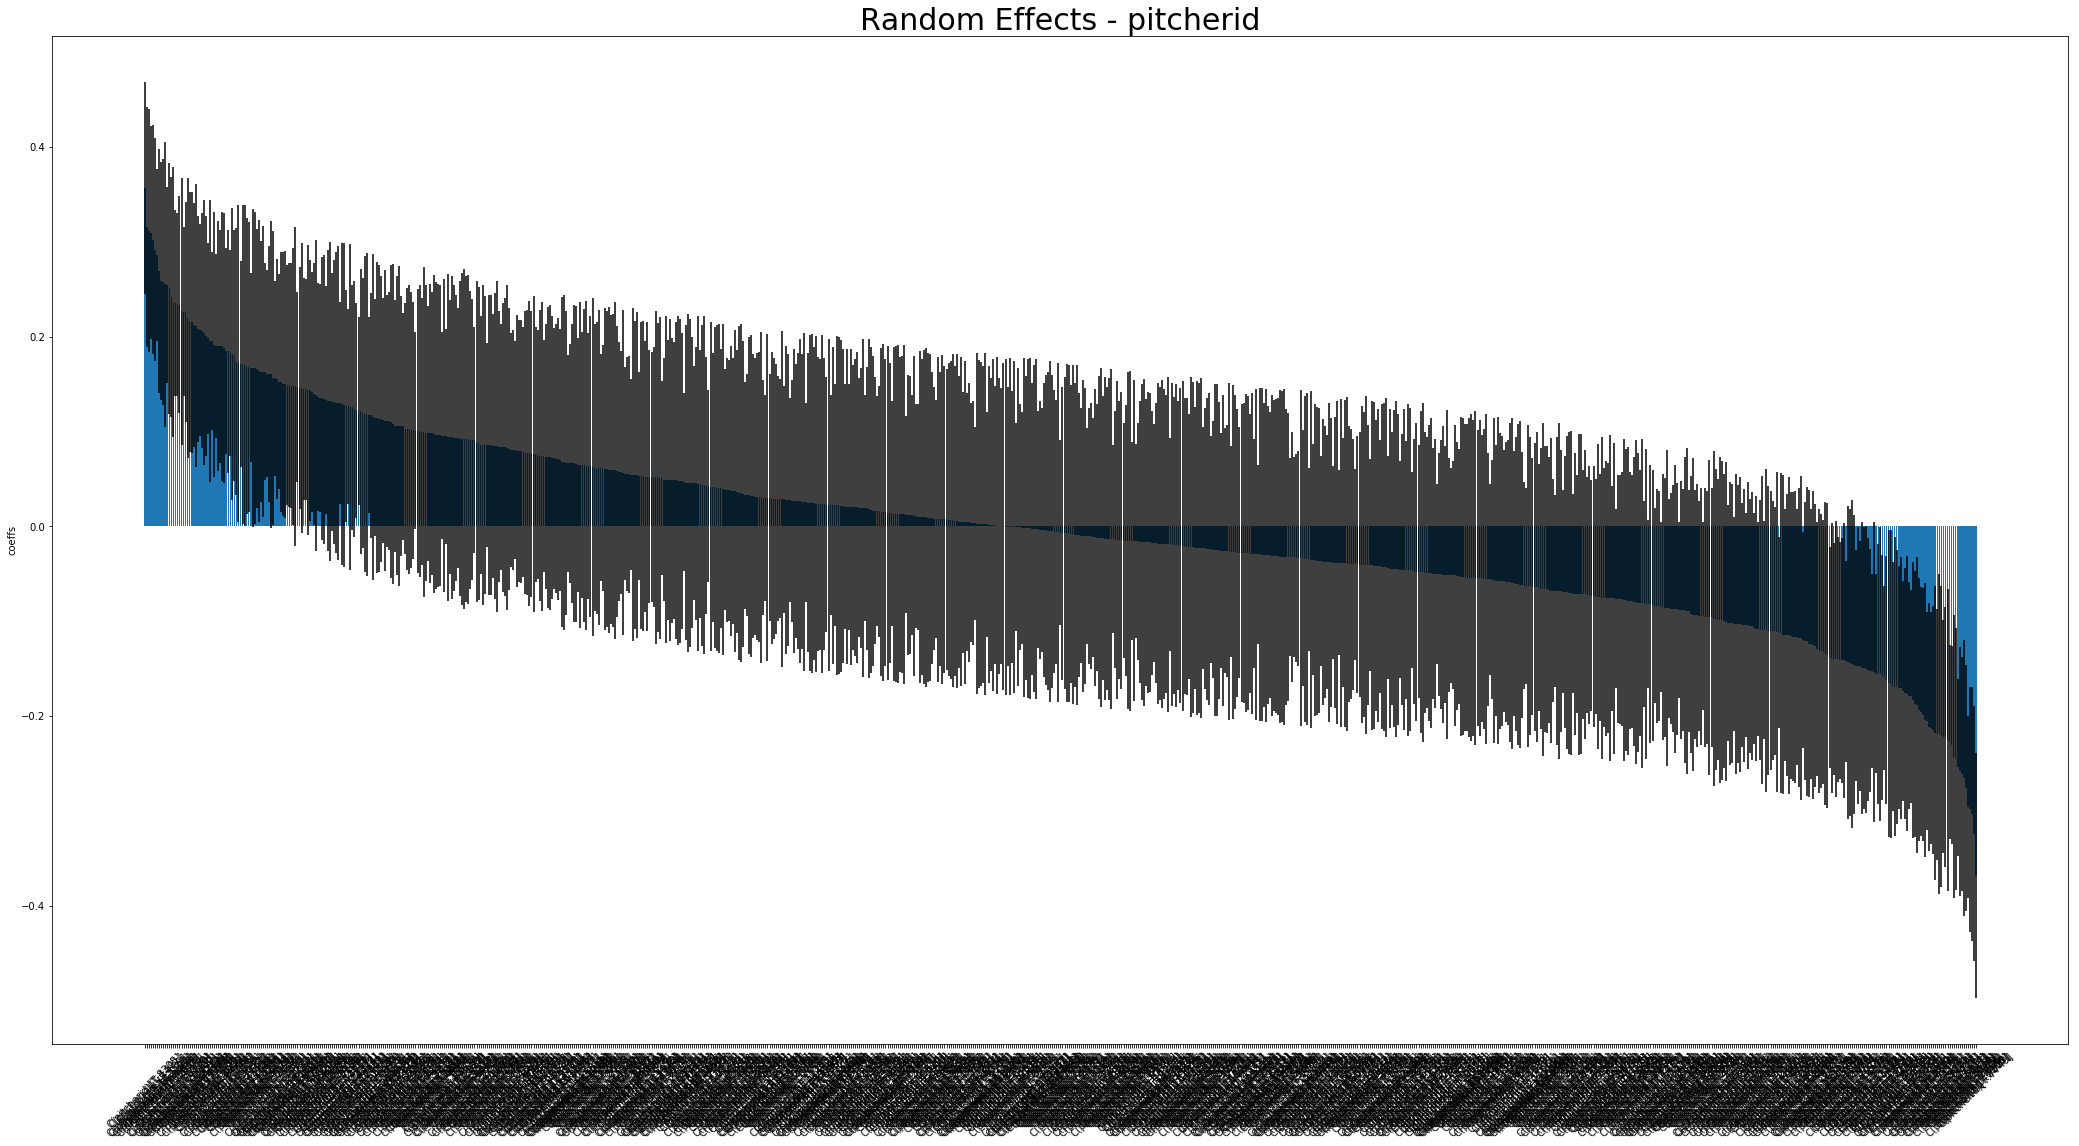

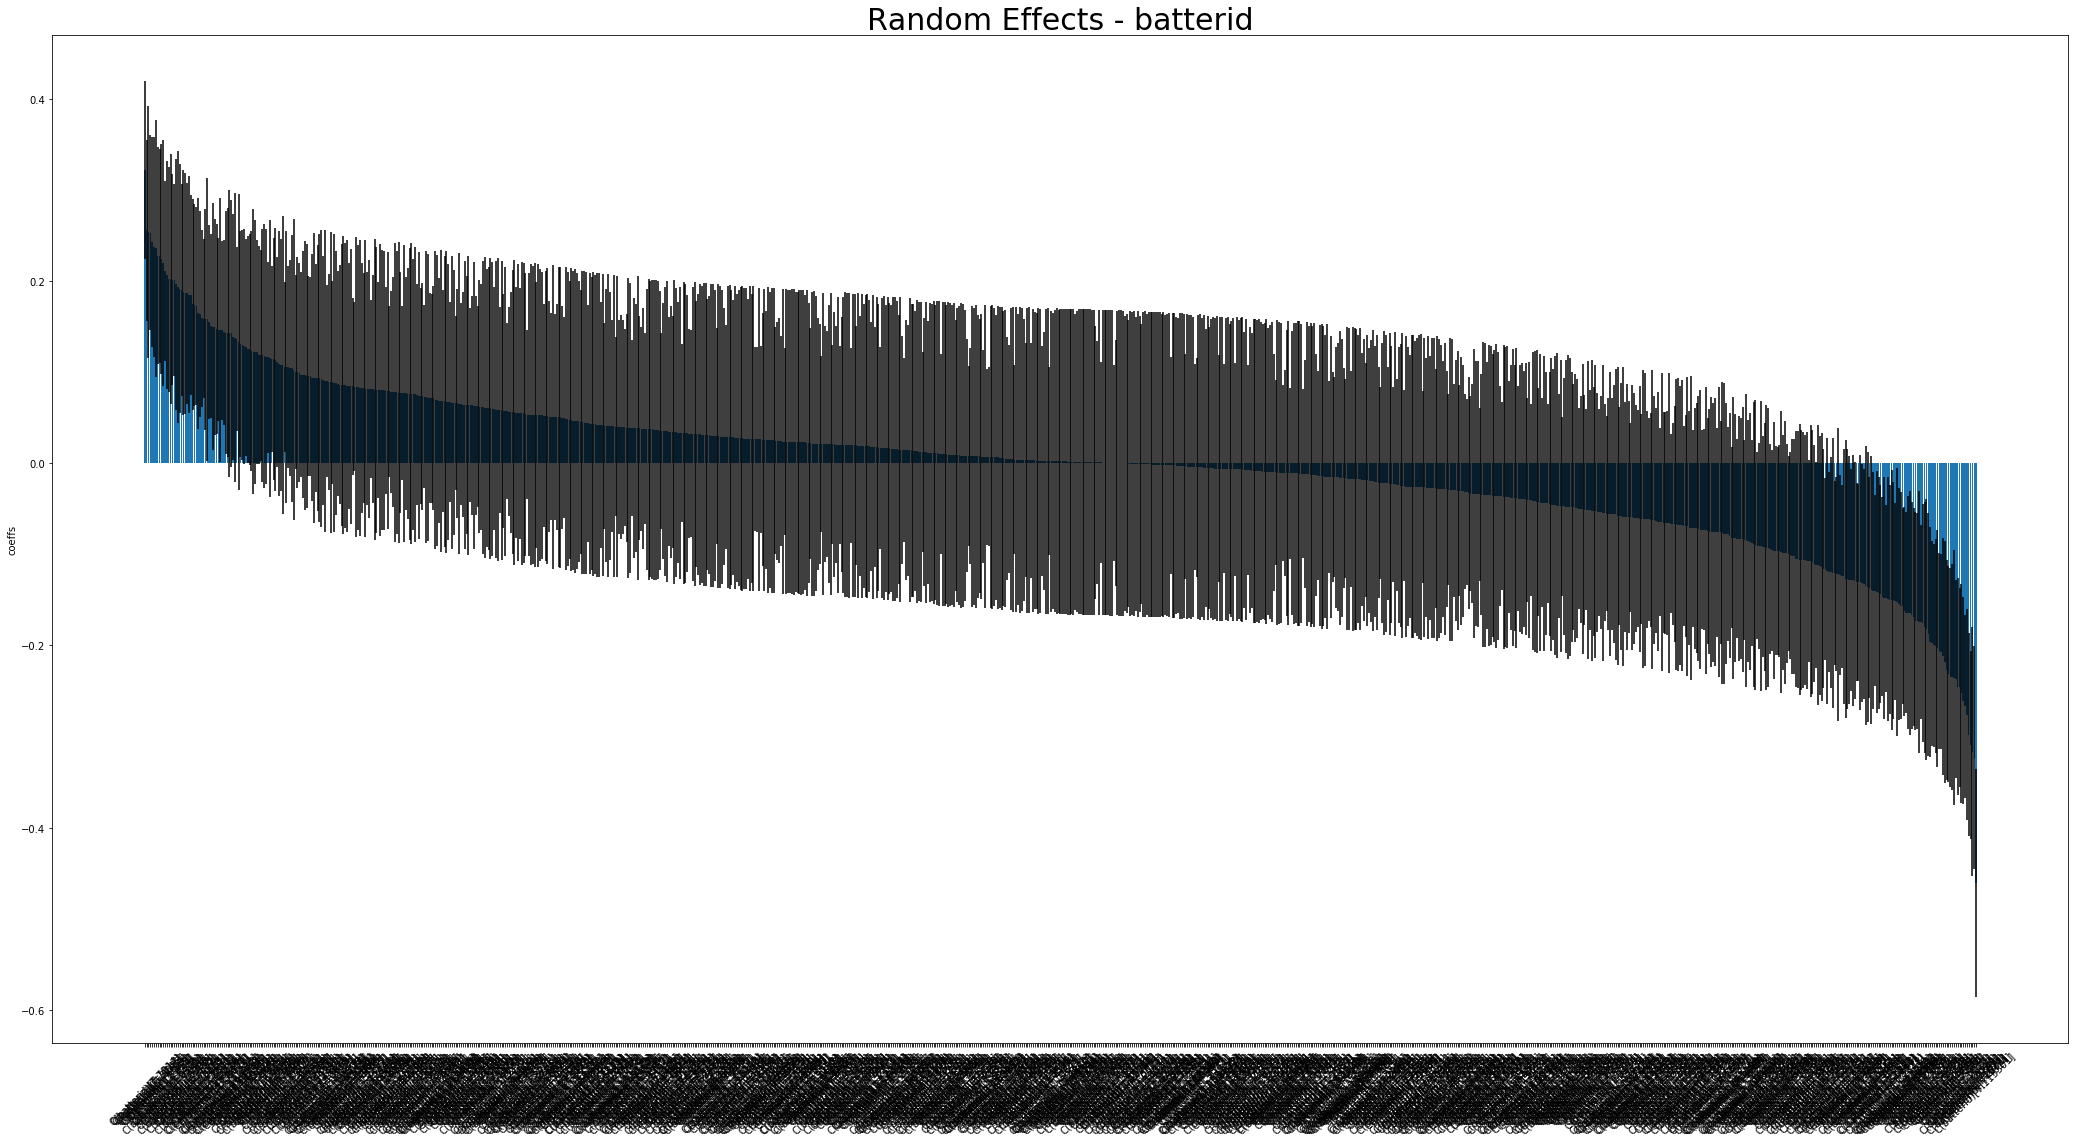

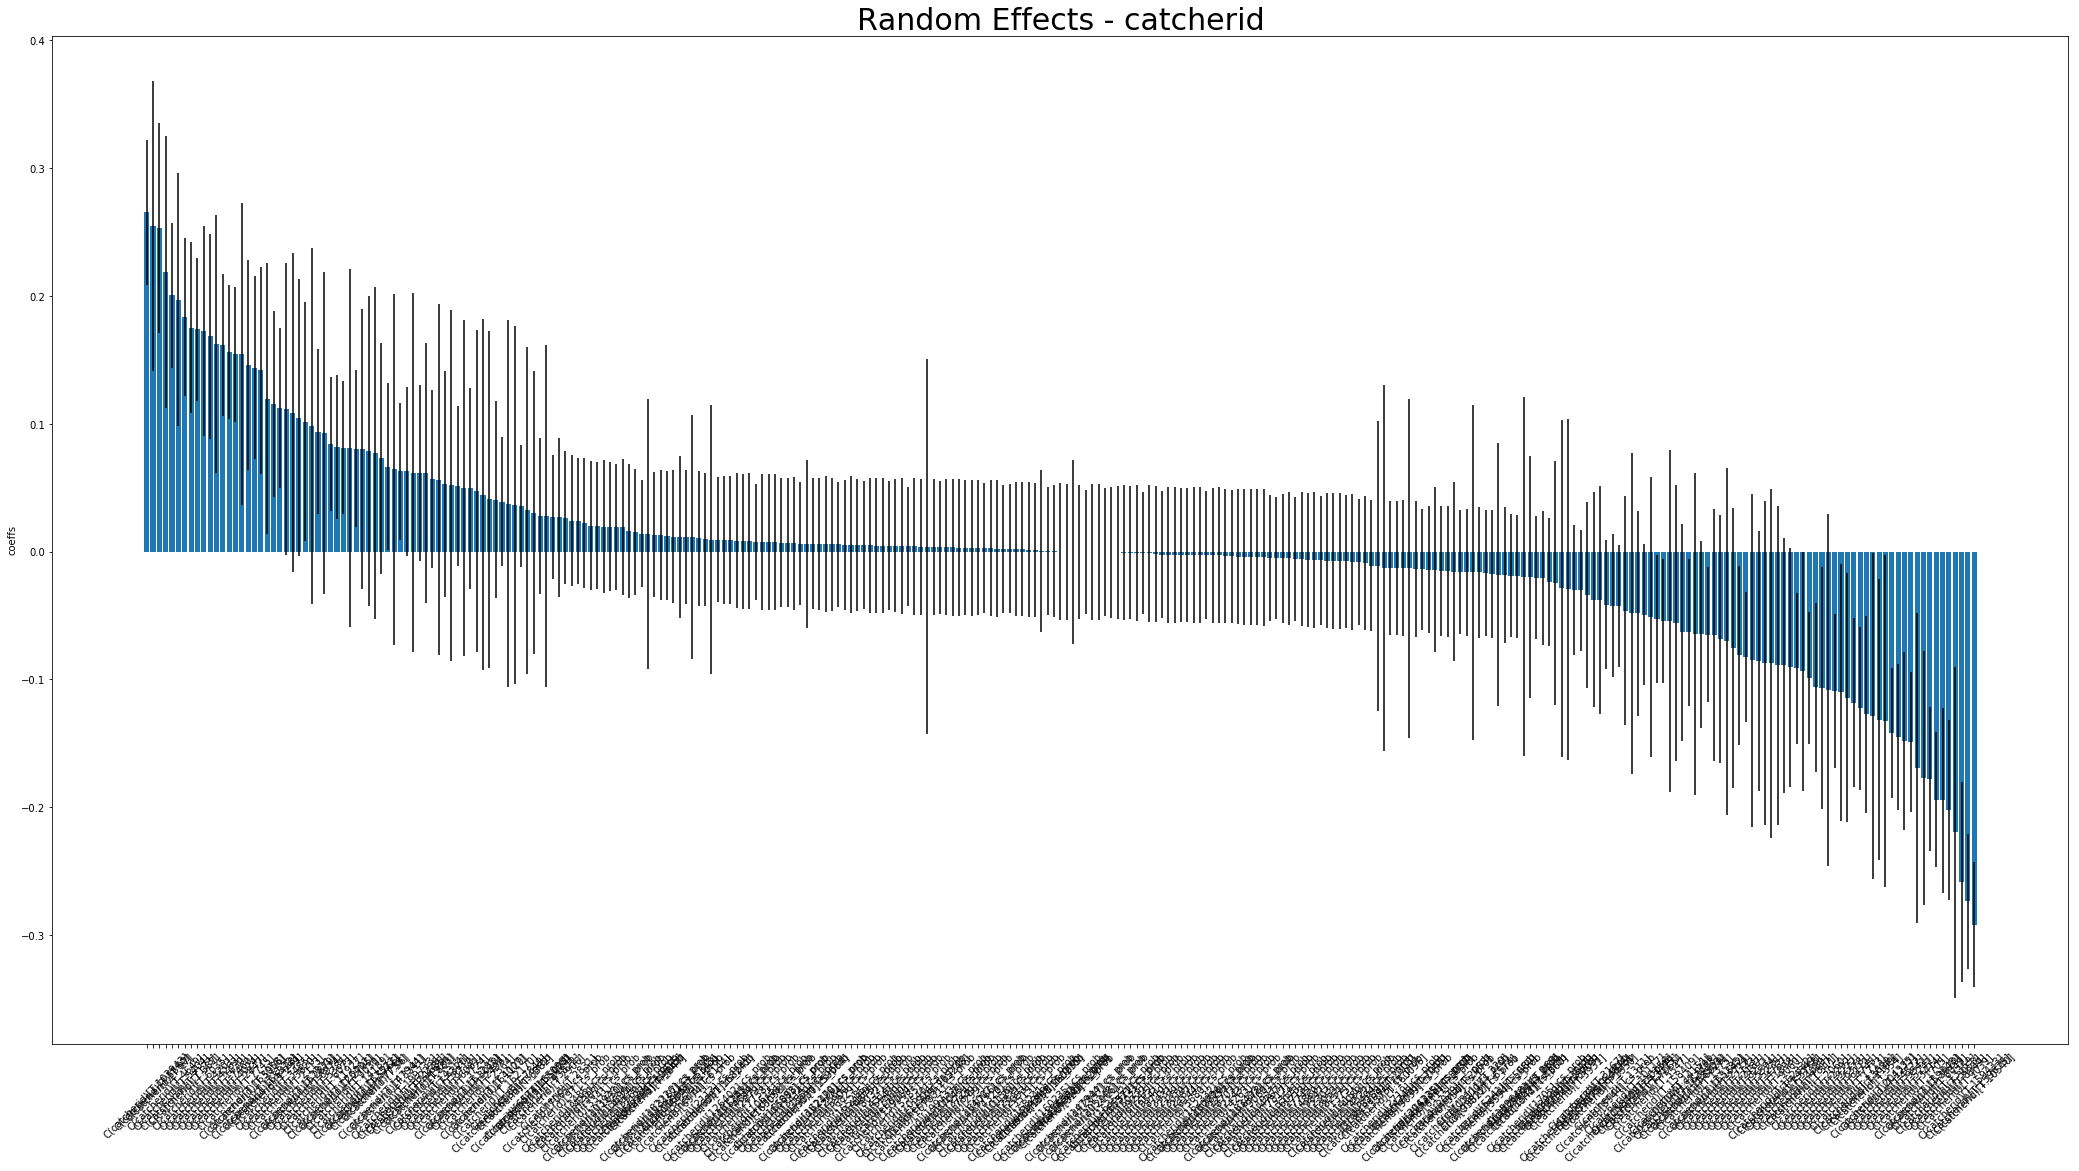

In [130]:
for effect in ['ump_hp','parkid','pitcherid','batterid','catcherid']:
    plot_effect_factors(effect, random)

In [132]:
get_random_effect_factors('catcherid', random).sort_values('Mean',ascending=False)

,Mean,SD
C(catcherid)[T.103943],0.265395,0.057057
C(catcherid)[T.5560],0.254574,0.113406
C(catcherid)[T.97],0.253104,0.081959
C(catcherid)[T.4649],0.218734,0.106254
C(catcherid)[T.5404],0.200502,0.056575
C(catcherid)[T.7123],0.197308,0.098812
C(catcherid)[T.387],0.183658,0.062127
C(catcherid)[T.6035],0.175303,0.066850
C(catcherid)[T.4201],0.173885,0.056011
C(catcherid)[T.4263],0.172756,0.082009


In [190]:
fixed_effect = np.matmul(np.mean(model.data.exog, axis=0),model_fitted.fe_mean)
baseline_prob = norm.cdf(fixed_effect)

In [179]:
fixed_effect

-1.1053535586713004

In [267]:
catchers = get_random_effect_factors('catcherid', random).sort_values('Mean',ascending=False)

In [268]:
def extract_id(df,id_name):
    return df[id_name].replace('C({})'.format(id_name),'')[3:-1]

In [269]:
catchers.reset_index(inplace=True)
catchers.rename(columns={'index':'catcherid'}, inplace=True)
catchers['catcherid'] = catchers.apply(extract_id, args=['catcherid'], axis=1)

In [270]:
def calc_random_effect_prob(df):
    z = df['Mean'] + fixed_effect
    return norm.cdf(z)

def calc_random_effect_prob_added(df):
    return df['prob'] - norm.cdf(fixed_effect)

In [271]:
catchers['prob'] = catchers.apply(calc_random_effect_prob, axis=1)

In [272]:
catchers['CSAA'] = catchers.apply(calc_random_effect_prob_added, axis=1)

In [275]:
catchers.set_index('catcherid')['CSAA']*7000*.14

catcherid
103943    64.643337
5560      61.683730
97        61.284027
4649      52.075915
5404      47.303361
7123      46.475301
387       42.963769
6035      40.835955
4201      40.476287
4263      40.190507
1630      39.089718
7460      37.640102
4024      37.442385
2847      35.956504
7745      35.592391
163058    35.585006
5906      33.452416
165572    33.020248
6428      32.521664
299       27.130146
3485      26.031927
3820      25.303050
2113      25.103080
167831    24.501987
2879      23.530477
6974      22.833773
5385      22.014446
6073      20.913976
11927     20.779218
126402    18.725892
            ...    
4089     -18.274621
7817     -18.392001
311      -18.867604
2060     -19.843021
2292     -21.227894
9222     -21.335558
6378     -21.616302
6111     -21.755701
4745     -21.943575
1713     -22.717240
13699    -23.483984
2199     -24.288282
354      -25.129561
204335   -25.364803
1277     -25.878982
4522     -26.131250
9541     -27.780404
5241     -28.356280
3414     -